## Imports

In [124]:
# To embed plots in the notebooks
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np # numpy library
import scipy.linalg as lng # linear algebra from scipy library
from sklearn import preprocessing as preproc # load preprocessing function

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [125]:
prostatePath = 'Prostate.txt'

T = np.loadtxt(prostatePath, delimiter = ' ', skiprows = 1, usecols=[1,2,3,4,5,6,7,8,9])

y = T[:, 0]
X = T[:,1:]

[n, p] = np.shape(X)

#Our chosen normalization centers and normalize the variables of a data matrix to unit length.
# We can use sklearn "Normalizer" to do this, but we must transpose the matrices to act on the variables instead of samples
X_pre = X - np.mean(X,axis=0)
y_pre = y - np.mean(y,axis=0)

beta_real = np.linalg.inv(X_pre.T @ X_pre) @ X_pre.T @ y_pre

normalizer = preproc.Normalizer().fit(X_pre.T)  
X_pre = normalizer.transform(X_pre.T).T

## 1 Perform model selection for ridge regression (for the prostate data set):
> (a) Consider using ridge-regression solutions for the prostate data set. What is a suitable range for the shrinkage parameter $λ$ in which to search for an optimal solution in?

In [126]:
def ridgeMulti(X, _lambda, p, y):
    betas = np.linalg.inv(X.T @ X + _lambda * np.eye(p)) @ X.T @ y
    error = np.linalg.norm(y - X @ betas)

    return betas, error

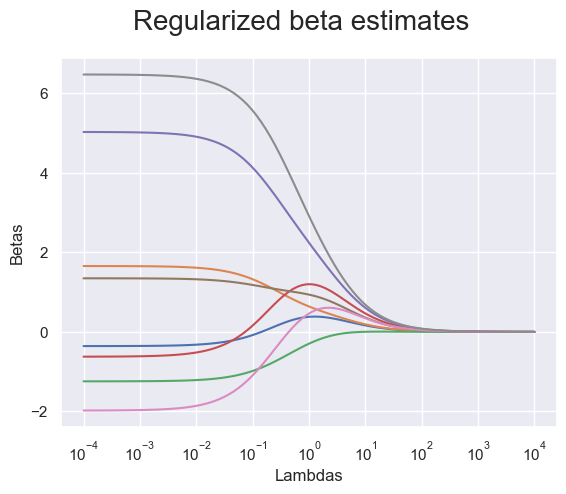

In [127]:
k = 100
lambdas = np.logspace(-4, 4, k)

betas = np.zeros((k, p))
for i, _lambda in enumerate(lambdas):
    beta, error = ridgeMulti(X_pre, _lambda, p, y_pre)
    betas[i] = beta 

plt.figure()
plt.semilogx(lambdas, betas)
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle("Regularized beta estimates", fontsize=20)
plt.show()

What is a suitable range for $λ$ in which to search for an optimal solution?

> (b) Select a suitable value for the regularization parameter using K-fold cross-validation. Plot the resulting optimal value of lambda on a plot of the parameter trace (i.e. a plot of the $\hat{β}_j$s as a function of $λ$).

>> (i) Try one of the common choices K = 5 and K = 10, and run the cross- validation a couple of times. Which would you prefer and why?
*Hint: To do Crossvalidation create a vector of length n that contains equal amounts of numbers from 1 to K and permute that vector.*

In [128]:
def centerData(data):
    mu = np.mean(data, axis=0)
    data = data - mu
    sigma = np.std(data, axis=0)
    data = data / sigma
    
    return data, mu, sigma

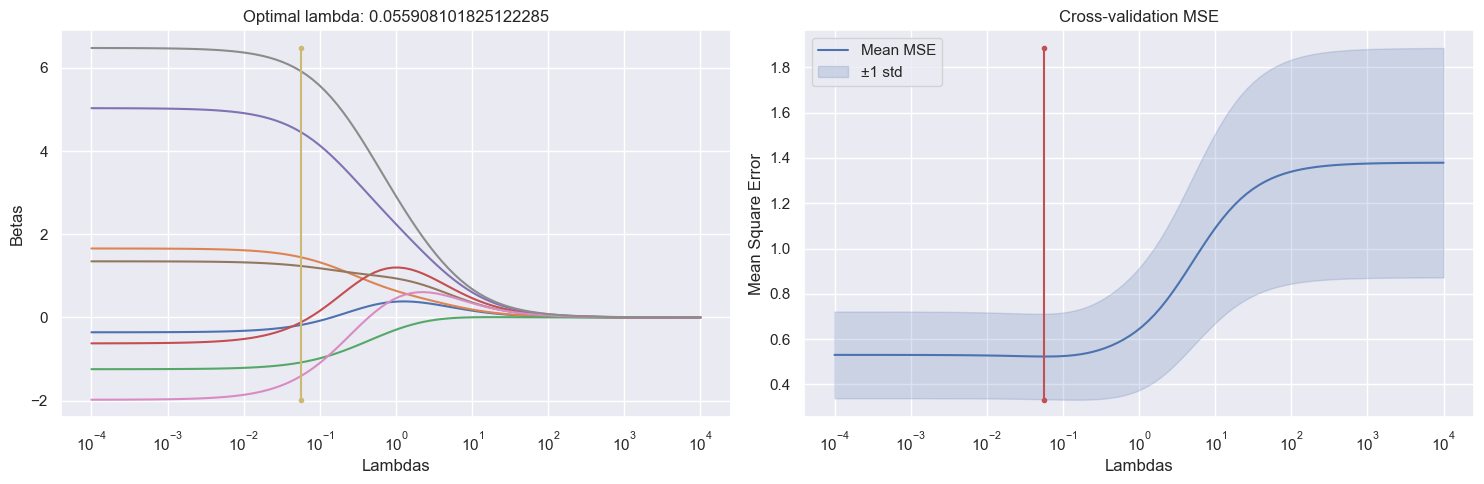

In [129]:
K = 10

lambdas = np.logspace(-4, 4, k)

# Create vector of length n with equal amounts of numbers 1 to K
n = len(X_pre)
fold_indices = np.repeat(np.arange(1,K+1), n//K)
# Add any remaining indices if n not perfectly divisible by K
if len(fold_indices) < n:
    fold_indices = np.append(fold_indices, np.arange(1,K+1)[:(n-len(fold_indices))])

# Permute the vector randomly
np.random.shuffle(fold_indices)

# Initialize arrays to store errors
MSE = np.zeros((K, len(lambdas)))

# For each fold
for i in range(1, K + 1):
    # Split into training and validation sets
    train_mask = fold_indices != i
    val_mask = fold_indices == i
    
    X_train = X_pre[train_mask]
    y_train = y_pre[train_mask]
    X_val = X_pre[val_mask]
    y_val = y_pre[val_mask]
    
    # For each lambda value
    for j, _lambda in enumerate(lambdas):
        # Fit model on training data
        beta, _ = ridgeMulti(X_train, _lambda, p, y_train)
        
        # Calculate MSE on validation set
        y_pred = X_val @ beta
        MSE[i - 1, j] = np.mean((y_val - y_pred) ** 2)

# Average MSE across folds
mean_MSE = np.mean(MSE, axis=0)
# Calculate standard deviation of MSE
std_MSE = np.std(MSE, axis=0)

# Find optimal lambda
lambda_OP = lambdas[np.argmin(mean_MSE)]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Beta coefficients
ax1.semilogx(lambdas, betas)
ax1.set_xlabel("Lambdas")
ax1.set_ylabel("Betas")
ax1.set_title(f"Optimal lambda: {lambda_OP}")
ax1.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")

# Plot 2: MSE with standard deviation band
ax2.semilogx(lambdas, mean_MSE, 'b-', label='Mean MSE')
ax2.fill_between(lambdas, 
                 mean_MSE - std_MSE,
                 mean_MSE + std_MSE,
                 alpha=0.2,
                 color='b',
                 label='±1 std')
ax2.set_xlabel("Lambdas")
ax2.set_ylabel("Mean Square Error")
ax2.set_title("Cross-validation MSE")
ax2.semilogx([lambda_OP, lambda_OP], [np.min(mean_MSE - std_MSE), np.max(mean_MSE + std_MSE)], 'r-', marker=".")
ax2.legend()

plt.tight_layout()
plt.show()

Where should you normalize your data?

(ii) What is the value of K corresponding to leave-one-out cross-validation?

> (c) Find a suitable value of $λ$ using the one-standard-error rule. What is the difference between the two strategies (cross-validation and cross-validation with one- standard-error-rule)?

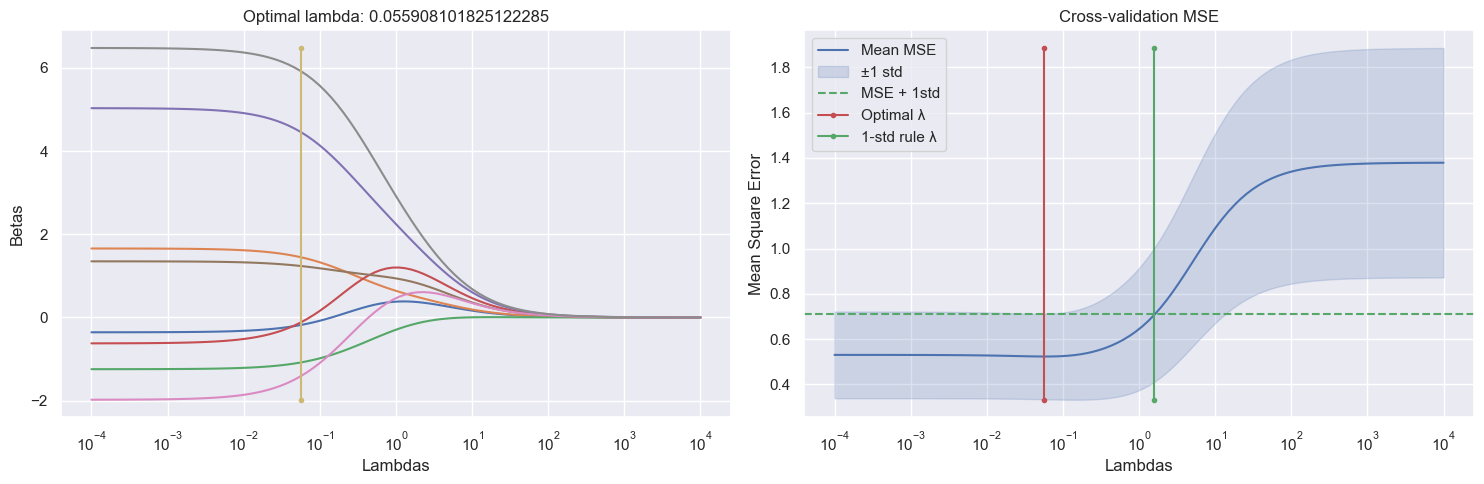

CV lambda with 1-std-rule 1.59


In [130]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.

# Get MSE and std at optimal lambda index
opt_idx = np.argmin(mean_MSE)
opt_MSE = mean_MSE[opt_idx]
opt_std = std_MSE[opt_idx]

# Find largest lambda with MSE within 1 std of optimal
valid_lambdas = lambdas[mean_MSE <= opt_MSE + opt_std]
Lambda_CV_1StdRule = valid_lambdas[-1]  # Take largest valid lambda

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Beta coefficients
ax1.semilogx(lambdas, betas)
ax1.set_xlabel("Lambdas")
ax1.set_ylabel("Betas")
ax1.set_title(f"Optimal lambda: {lambda_OP}")
ax1.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")

# Plot 2: MSE with standard deviation band
ax2.semilogx(lambdas, mean_MSE, 'b-', label='Mean MSE')
ax2.fill_between(lambdas, 
                 mean_MSE - std_MSE,
                 mean_MSE + std_MSE,
                 alpha=0.2,
                 color='b',
                 label='±1 std')
ax2.set_xlabel("Lambdas")
ax2.set_ylabel("Mean Square Error")
ax2.set_title("Cross-validation MSE")

# Add horizontal line at MSE + 1std
ax2.axhline(y=opt_MSE + opt_std, color='g', linestyle='--', label='MSE + 1std')

# Add vertical lines for optimal lambda and 1-std rule lambda
ax2.semilogx([lambda_OP, lambda_OP], [np.min(mean_MSE - std_MSE), np.max(mean_MSE + std_MSE)], 'r-', marker=".", label='Optimal λ')
ax2.semilogx([Lambda_CV_1StdRule, Lambda_CV_1StdRule], [np.min(mean_MSE - std_MSE), np.max(mean_MSE + std_MSE)], 'g-', marker=".", label='1-std rule λ')

ax2.legend()

plt.tight_layout()
plt.show()

print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

> (d) Select suitable values for the regularization parameter using the AIC and BIC criteria (cf. 7.5-7.7 in ESL). What are the advantages and disadvantages of using cross-validation vs. information criteria?

In [131]:
D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

# Calculate degrees of freedom, AIC and BIC for each lambda
for i, lambda_ in enumerate(lambdas):
    # Calculate ridge regression for this lambda
    beta_ridge = np.linalg.solve(X_pre.T @ X_pre + lambda_ * np.eye(X_pre.shape[1]), X_pre.T @ y_pre)
    
    # Calculate hat matrix H = X(X'X + λI)^(-1)X'
    H = X_pre @ np.linalg.solve(X_pre.T @ X_pre + lambda_ * np.eye(X_pre.shape[1]), X_pre.T)
    
    # Degrees of freedom is trace of hat matrix
    D[i] = np.trace(H)
    
    # Calculate residuals
    y_pred = X_pre @ beta_ridge
    residuals = y_pre - y_pred
    RSS = np.sum(residuals ** 2)
    n = len(y_pre)

    beta_ols, _, _, _ = lng.lstsq(X_pre, y_pre)
    s2 = np.mean((y_pre - X_pre @ beta_ols) ** 2)
    s = np.sqrt(s2)

    e = y - X_pre @ beta_ridge
    err = np.sum(e ** 2) / n
    
    # Calculate AIC and BIC
    AIC[i] = err + 2 * D[i] / n * s ** 2
    BIC[i] = n / (s ** 2) * (err + np.log(n) * D[i] / n * s ** 2)

# Find lambda with minimum AIC and BIC
jAIC = np.argmin(AIC)
jBIC = np.argmin(BIC)

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 0.05
BIC at 0.14


Text(0, 0.5, 'd')

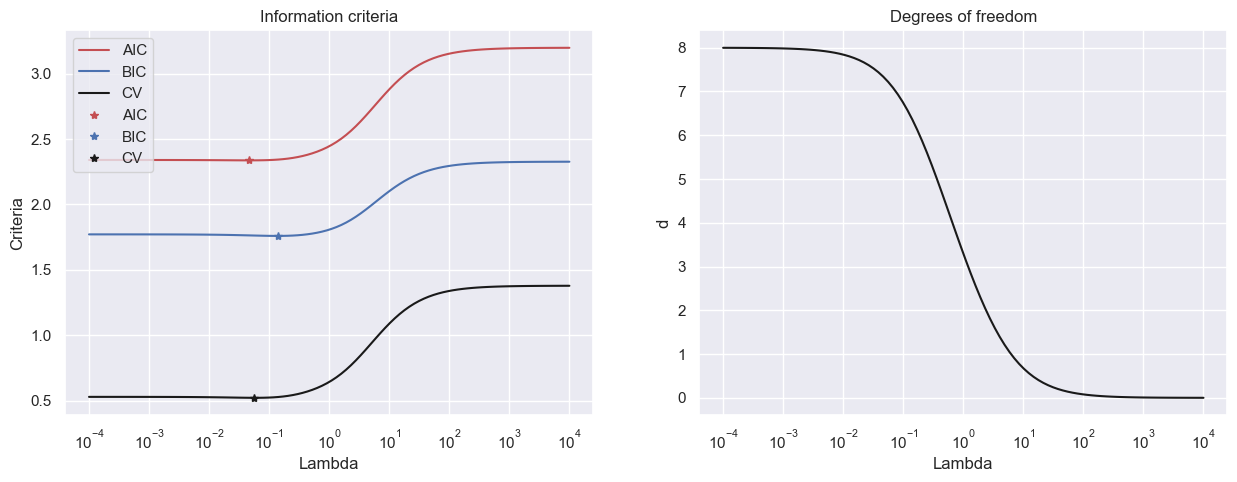

In [132]:
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas, AIC, '-r', label = 'AIC')
axs[0].semilogx(lambdas, BIC / 300,'-b', label = 'BIC')
axs[0].semilogx(lambdas, mean_MSE,'-k', label = 'CV')
axs[0].semilogx(lambdas[jAIC], np.min(AIC), '*r', label = 'AIC')
axs[0].semilogx(lambdas[jBIC], np.min(BIC) / 300, '*b', label = 'BIC')
axs[0].semilogx(lambdas[opt_idx], np.min(mean_MSE), '*k', label = 'CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#plot the degree of freedom
axs[1].semilogx(lambdas, D, '-k')
axs[1].set_title('Degrees of freedom')
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('d')

> (e) Use the bootstrap to estimate the variance of the parameters of the solution $(β)$ for each value of lambda in exercise 1a. Plot the variance estimates as a function of lambda. What do you notice?

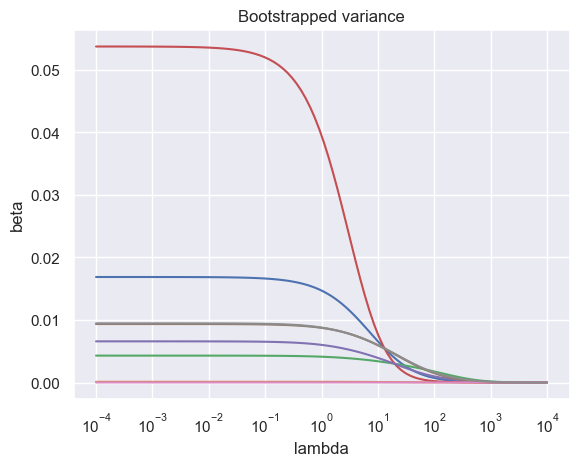

In [138]:
NBoot = 100
Beta = np.zeros((p, len(lambdas), NBoot))

# Run bootstrap for each lambda value
for i in range(NBoot):
    idx = np.random.randint(0, len(y), len(y))
    X_boot = X[idx]
    y_boot = y[idx]
    
    for j, lambda_ in enumerate(lambdas):
        beta, _ = ridgeMulti(X_boot, lambda_, p, y_boot)
        Beta[:, j, i] = beta

# Calculate standard deviation across bootstrap samples
stdBeta = np.var(Beta, axis=2)

# Plot the variance of the betas for each lambda value
plt.figure()
for i in range(8):
    plt.semilogx(lambdas, stdBeta[i,:])
plt.title("Bootstrapped variance")
plt.ylabel("beta")
plt.xlabel("lambda")
plt.show()